In [1]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("ananthu017/emotion-detection-fer")

print("Path to dataset files:", path)

c:\Users\kainak0\Documents\gitProjects\mia\MIA-203_redes_neuronales\parcial\facial_expression_recognition\ferpy\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Path to dataset files: C:\Users\kainak0\.cache\kagglehub\datasets\ananthu017\emotion-detection-fer\versions\1


In [2]:
# import kagglehub

# # Download latest version
# path = kagglehub.dataset_download("noamsegal/affectnet-training-data")

# print("Path to dataset files:", path)

In [3]:
!ls -la {path}

'ls' is not recognized as an internal or external command,
operable program or batch file.


In [4]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import datasets,transforms
from torch.utils.data import random_split,Dataset, DataLoader
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

In [5]:
train = os.path.join(path, 'train')
test = os.path.join(path, 'test')
classes_train = os.listdir(train)
classes_train_size = []
classes_test = os.listdir(test)
classes_test_size = []

for i in range(len(classes_train)):
    size = len(os.listdir(train+'/'+classes_train[i]))
    print(f"# of images in class train {classes_train[i]}: {size}")
    classes_train_size.append(size)
    print(f"total : {sum(classes_train_size)}")
for i in range(len(classes_test)):
    size = len(os.listdir(train+'/'+classes_test[i]))
    print(f"# of images in class test {classes_test[i]}: {size}")
    classes_train_size.append(size)
    print(f"total : {sum(classes_test_size)}")



# of images in class train angry: 3995
total : 3995
# of images in class train disgusted: 436
total : 4431
# of images in class train fearful: 4097
total : 8528
# of images in class train happy: 7215
total : 15743
# of images in class train neutral: 4965
total : 20708
# of images in class train sad: 4830
total : 25538
# of images in class train surprised: 3171
total : 28709
# of images in class test angry: 3995
total : 0
# of images in class test disgusted: 436
total : 0
# of images in class test fearful: 4097
total : 0
# of images in class test happy: 7215
total : 0
# of images in class test neutral: 4965
total : 0
# of images in class test sad: 4830
total : 0
# of images in class test surprised: 3171
total : 0


In [6]:
img = Image.open(os.path.join(train,'angry/im1.png'))

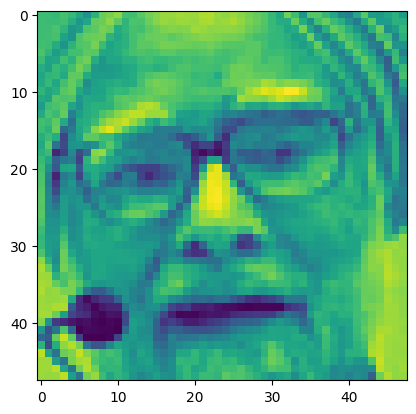

In [7]:
plt.imshow(img)

# RestNET

In [8]:
# Define a residual block
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)

        # Shortcut connection
        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )

    def forward(self, x):
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        out += self.shortcut(x)
        out = self.relu(out)
        return out


In [9]:
# Define the ResNet model
class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=7):
        super(ResNet, self).__init__()
        self.in_channels = 16
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(16)
        self.relu = nn.ReLU(inplace=True)
        self.layer1 = self._make_layer(block, 16, num_blocks[0])
        self.layer2 = self._make_layer(block, 32, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 64, num_blocks[2], stride=2)
        self.avg_pool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(64, num_classes)

    def _make_layer(self, block, out_channels, blocks, stride=1):
        layers = []
        layers.append(block(self.in_channels, out_channels, stride))
        self.in_channels = out_channels
        for _ in range(1, blocks):
            layers.append(block(out_channels, out_channels))
        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.avg_pool(x)
        x = x.view(x.size(0), -1)  # Flatten the output
        x = self.fc(x)
        return x

In [10]:
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'
os.environ['TORCH_USE_CUDA_DSA'] = '1'

In [11]:
# Create the ResNet model
def ResNet18():
    return ResNet(ResidualBlock, [2, 2, 2], num_classes=7)  # ResNet-18

# Initialize the model, loss function, and optimizer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = ResNet18().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.004)

In [12]:
### Acondicionamiento del dataset
# Definir transformaciones de preprocesamiento
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Cambiar el tamaño de las imágenes
    transforms.ToTensor(),          # Convertir las imágenes en tensores
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])  # Normalización
])

# Cargar el dataset

dataset_train = datasets.ImageFolder(os.path.join(train), transform=transform)
dataset_test = datasets.ImageFolder(os.path.join(test), transform=transform)

train_size, val_size = int(len(dataset_train)), int(len(dataset_test))


train_loader = DataLoader(dataset_train, batch_size=64, shuffle=True) # shuffle to avoid memorization (overfitting)
val_loader = DataLoader(dataset_test, batch_size=64, shuffle=False)

In [13]:
# Training the model
num_epochs = 100
for epoch in range(num_epochs):
    model.train()  # Set the model to training mode
    running_loss = 0.0
    for data in train_loader:
        inputs, labels = data[0].to(device), data[1].to(device)

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}')

Epoch [1/100], Loss: 1.7975
Epoch [2/100], Loss: 1.7843
Epoch [3/100], Loss: 1.7650
Epoch [4/100], Loss: 1.7466
Epoch [5/100], Loss: 1.7055
Epoch [6/100], Loss: 1.6166
Epoch [7/100], Loss: 1.5028
Epoch [8/100], Loss: 1.4191
Epoch [9/100], Loss: 1.3529
Epoch [10/100], Loss: 1.2913
Epoch [11/100], Loss: 1.2454
Epoch [12/100], Loss: 1.2053
Epoch [13/100], Loss: 1.1725
Epoch [14/100], Loss: 1.1454
Epoch [15/100], Loss: 1.1100
Epoch [16/100], Loss: 1.0815
Epoch [17/100], Loss: 1.0531
Epoch [18/100], Loss: 1.0250
Epoch [19/100], Loss: 0.9937
Epoch [20/100], Loss: 0.9656
Epoch [21/100], Loss: 0.9375
Epoch [22/100], Loss: 0.9074
Epoch [23/100], Loss: 0.8712
Epoch [24/100], Loss: 0.8389
Epoch [25/100], Loss: 0.8018
Epoch [26/100], Loss: 0.7703
Epoch [27/100], Loss: 0.7337
Epoch [28/100], Loss: 0.7013
Epoch [29/100], Loss: 0.6597
Epoch [30/100], Loss: 0.6264
Epoch [31/100], Loss: 0.5840
Epoch [32/100], Loss: 0.5676
Epoch [33/100], Loss: 0.5243
Epoch [34/100], Loss: 0.4870
Epoch [35/100], Loss: 0

### Testing

In [19]:
### Testing
# Testing the model
model.eval()  # Set the model to evaluation mode
correct = 0
total = 0
with torch.no_grad():
    for data in val_loader:
        images, labels = data[0].to(device), data[1].to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the model on the 10,000 test images: {100 * correct / total:.2f}%')

Accuracy of the model on the 10,000 test images: 48.51%


In [15]:
torch.save(model.state_dict(), 'models/ResNET_FER.pth')

In [1]:
import matplotlib.pyplot as plt
import random
import torchvision

def show_random_test_predictions(model, dataloader, class_names, num_images=16):
    model.eval()
    images_shown = 0
    fig, axes = plt.subplots(6, 6, figsize=(12, 12))
    axes = axes.flatten()

    all_images = []
    all_labels = []
    all_preds = []

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            all_images.extend(inputs.cpu())
            all_labels.extend(labels.cpu())
            all_preds.extend(preds.cpu())

    combined = list(zip(all_images, all_labels, all_preds))
    random.shuffle(combined)

    selected_images = random.sample(combined, min(num_images, len(combined)))

    for idx, (img, label, pred) in enumerate(selected_images):
        ax = axes[images_shown]
        ax.axis('off')

        img = img.numpy().transpose((1, 2, 0))
        img = np.clip((img * [0.229, 0.224, 0.225]) + [0.485, 0.456, 0.406], 0, 1)

        ax.imshow(img)

        predicted_class = class_names[pred]
        actual_class = class_names[label]
        title = f'Actual: {class_names[label]}\nPredicted: {class_names[pred]}'

        if predicted_class == actual_class:
            ax.set_title(title, color='green',fontsize=8)
        else:
            ax.set_title(title, color='red',fontsize=8)

        images_shown += 1
        if images_shown == num_images:
            break

    plt.tight_layout()
    plt.show()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
path = 'models/ResNET_FER_48.pth'
model = ResNet18().to(device)
model.load_state_dict(torch.load(path))
show_random_test_predictions(model, val_loader, classes_train, num_images=36)

NameError: name 'torch' is not defined

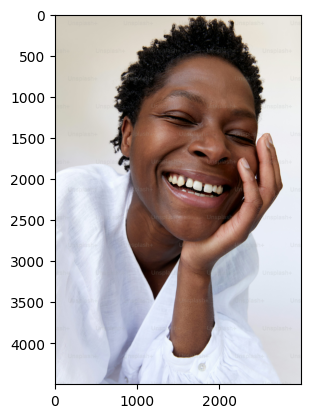

In [17]:
img = Image.open('prueba.jpeg')
plt.imshow(img)

### Validation

In [18]:

# Training Results
print('hi')


hi
